# Genera imágenes desde frases de texto con VQGAN y CLIP (método z+quantize con augmentations).

Notebook hecho por Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings). El método BigGAN+CLIP original fue hecho por https://twitter.com/advadnoun. Traducido y agregadas explicaciones, y modificaciones por Eleiber#8347, y la interfaz amigable fue hecha gracias a Abulafia#3734.

Para un tutorial detallado de cómo usarlo, recomiendo [visitar este artículo](https://tuscriaturas.miraheze.org/wiki/Ayuda:Crear_imágenes_con_VQGAN+CLIP), hecho por Jakeukalane#2767 y Avengium (Ángel)#3715


In [ ]:
!nvidia-smi

In [ ]:
    # # @title Instalación de bibliotecas
# # @markdown Esta celda tardará un poco porque tiene que descargar varias librerías
 
# print("Descargando CLIP...")
# !git clone https://github.com/openai/CLIP                 
# print("Instalando bibliotecas de Python para IA...")
# !git clone https://github.com/CompVis/taming-transformers 
# !pip install ftfy regex tqdm omegaconf pytorch-lightning torch 
# !pip install kornia                                       
# !pip install einops                                       
 
# print("Instalando bibliotecas para manejo de metadatos...")
# !pip install stegano                                      
# !apt install exempi                                       
# !pip install python-xmp-toolkit                           
# !pip install imgtag                                       
# !pip install pillow==7.1.2                                
 
# print("Instalando bibliotecas de Python para creación de vídeos...")
# !pip install imageio-ffmpeg 
# !mkdir steps
# print("Instalación finalizada.")
# !pip install torchvision
# ! pip install imageio


In [ ]:
# #@title Selección de modelos a descargar
# #@markdown Por defecto, el notebook descarga el modelo 16384 de ImageNet. Existen otros como ImageNet 1024, COCO-Stuff, WikiArt 1024, WikiArt 16384, FacesHQ o S-FLCKR, que no se descargan por defecto, ya que sería en vano si no los vas a usar, así que si quieres usarlos, simplemente selecciona los modelos a descargar.

# imagenet_1024 = False #@param {type:"boolean"}
# imagenet_16384 = True #@param {type:"boolean"}
# coco = False #@param {type:"boolean"}
# faceshq = False #@param {type:"boolean"}
# wikiart_1024 = False #@param {type:"boolean"}
# wikiart_16384 = False #@param {type:"boolean"}
# sflckr = False #@param {type:"boolean"}

# if imagenet_1024:
#   !curl -L -o vqgan_imagenet_f16_1024.yaml -C - 'http://mirror.io.community/blob/vqgan/vqgan_imagenet_f16_1024.yaml' #ImageNet 1024
#   !curl -L -o vqgan_imagenet_f16_1024.ckpt -C - 'http://mirror.io.community/blob/vqgan/vqgan_imagenet_f16_1024.ckpt'  #ImageNet 1024
# if imagenet_16384:
#   !curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'http://mirror.io.community/blob/vqgan/vqgan_imagenet_f16_16384.yaml' #ImageNet 16384
#   !curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'http://mirror.io.community/blob/vqgan/vqgan_imagenet_f16_16384.ckpt' #ImageNet 16384
# if coco:
#   !curl -L -o coco.yaml -C - 'https://dl.nmkd.de/ai/clip/coco/coco.yaml' #COCO
#   !curl -L -o coco.ckpt -C - 'https://dl.nmkd.de/ai/clip/coco/coco.ckpt' #COCO
# if faceshq:
#   !curl -L -o faceshq.yaml -C - 'https://drive.google.com/uc?export=download&id=1fHwGx_hnBtC8nsq7hesJvs-Klv-P0gzT' #FacesHQ
#   !curl -L -o faceshq.ckpt -C - 'https://app.koofr.net/content/links/a04deec9-0c59-4673-8b37-3d696fe63a5d/files/get/last.ckpt?path=%2F2020-11-13T21-41-45_faceshq_transformer%2Fcheckpoints%2Flast.ckpt' #FacesHQ
# if wikiart_1024: 
#   !curl -L -o wikiart_1024.yaml -C - 'http://mirror.io.community/blob/vqgan/wikiart.yaml' #WikiArt 1024
#   !curl -L -o wikiart_1024.ckpt -C - 'http://mirror.io.community/blob/vqgan/wikiart.ckpt' #WikiArt 1024
# if wikiart_16384: 
#   !curl -L -o wikiart_16384.yaml -C - 'http://mirror.io.community/blob/vqgan/wikiart_16384.yaml' #WikiArt 16384
#   !curl -L -o wikiart_16384.ckpt -C - 'http://mirror.io.community/blob/vqgan/wikiart_16384.ckpt' #WikiArt 16384
# if sflckr:
#   !curl -L -o sflckr.yaml -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1' #S-FLCKR
#   !curl -L -o sflckr.ckpt -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' #S-FLCKR

In [1]:
 
import argparse
import math
from pathlib import Path
import sys
 
sys.path.append('./taming-transformers')
from IPython import display
from base64 import b64encode
from omegaconf import OmegaConf
from PIL import Image

from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
 
from CLIP import clip
import kornia.augmentation as K
import numpy as np
import imageio
from PIL import ImageFile, Image
from imgtag import ImgTag    # metadatos 
from libxmp import *         # metadatos
import libxmp                # metadatos
from stegano import lsb
import json

/home/sylv/.local/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(
/home/sylv/.local/lib/python3.8/site-packages/kornia/augmentation/augmentation.py:1872: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(


In [2]:
# @title Carga de bibliotecas y definiciones

ImageFile.LOAD_TRUNCATED_IMAGES = True
 
def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))
 
 
def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()
 
 
def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]
 
 
def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size
 
    input = input.view([n * c, 1, h, w])
 
    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])
 
    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])
 
    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
 
 
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply
 
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply
 
 
def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)
 
 
class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
 
    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()
 
 
def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])
 
 
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.augs = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            # K.RandomSolarize(0.01, 0.01, p=0.7),
            K.RandomSharpness(0.3,p=0.4),
            K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'),
            K.RandomPerspective(0.2,p=0.4),
            K.ColorJitter(hue=0.01, saturation=0.01, p=0.7))
        self.noise_fac = 0.1
 
 
    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch
 
 
def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model
 
 
def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

/home/sylv/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Herramientas para la ejecución:
Principalmente lo que tendrás que modificar será `textos:`, ahí puedes colocar el o los textos que  quieres generar (separados con `|` ). Es una lista porque puedes poner más de un texto, y así la IA trate de 'mezclar' las imágenes, dándole la misma prioridad a ambos textos.

Para usar una imagen inicial al modelo, solo debes subir un archivo al entorno del Colab (en la sección a la izquierda), y luego modificas `imagen_inicial:` poniendo el nombre exacto del archivo. Ejemplo: `sample.png`

También puedes modificar el modelo cambiando las línea que dice `modelo:`. Actualmente están disponibles 1024, 16384, WikiArt, S-FLCKR y COCO-Stuff. Para activarlos tienes que haberlos descargado primero, y luego puedes simplemente seleccionarlo.

También puedes usar `imagenes_objetivo`, que es básicamente ponerle una o más imágenes que la IA tomará como "meta", cumpliendo la misma función que ponerle un texto. Para poner más de una tienes que usar `|` como separador.

begin
done


/home/sylv/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/sylv/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using device: cpu
Using texts: ['a friendly intelligence that dreams images really opens new avenues of divination']
Using seed: 5279098890002019641
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt


/home/sylv/.local/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


0it [00:00, ?it/s]

/home/sylv/.local/lib/python3.8/site-packages/kornia/utils/helpers.py:96: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  out1, out2 = torch.solve(input.to(dtype), A.to(dtype))


i: 0, loss: 0.881661, losses: 0.881661


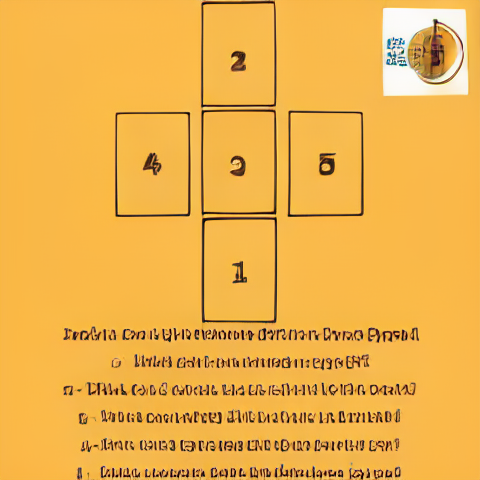

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
i: 20, loss: 0.823313, losses: 0.823313


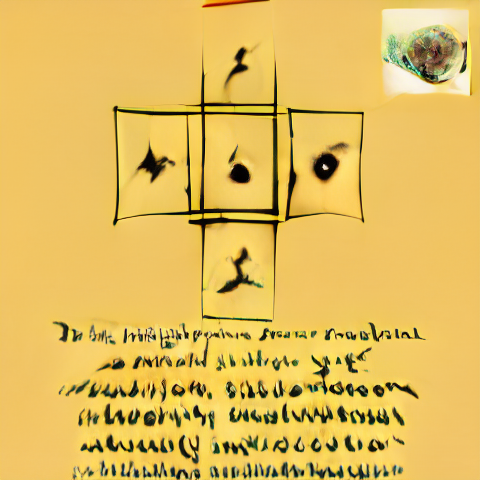

20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
i: 40, loss: 0.773986, losses: 0.773986


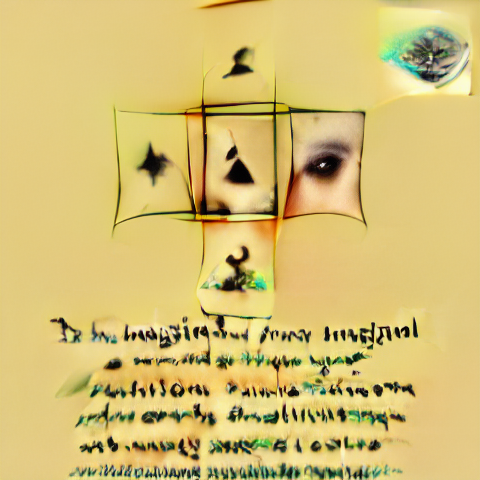

40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
i: 60, loss: 0.750805, losses: 0.750805


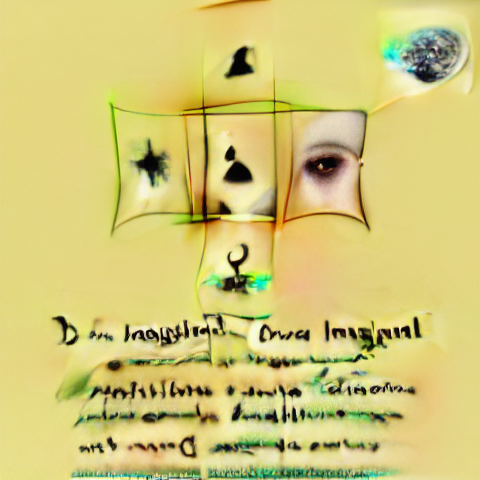

60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
i: 80, loss: 0.750117, losses: 0.750117


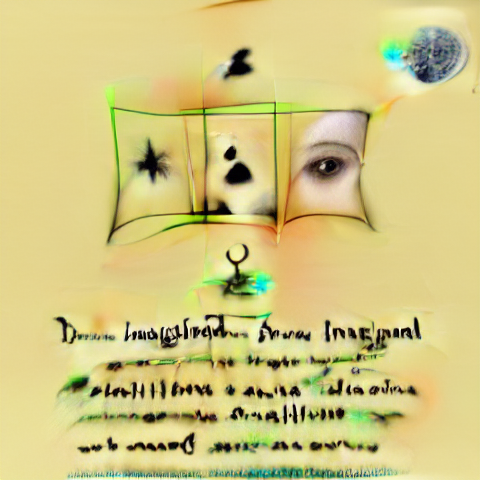

80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
i: 100, loss: 0.737232, losses: 0.737232


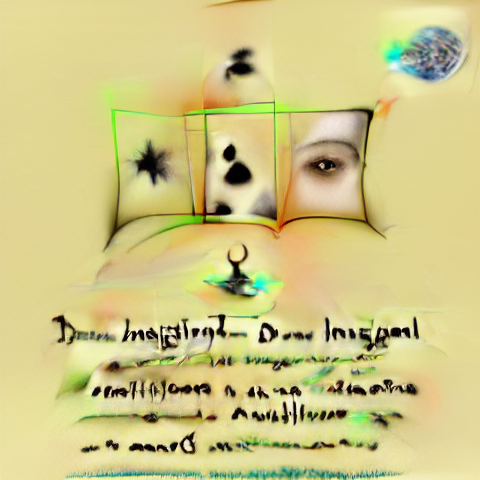

100
101


In [4]:

print("begin")
#@title Parámetros

textos = "a friendly intelligence that dreams images really opens new avenues of divination" #@param {type:"string"}
ancho =  480#@param {type:"number"}
alto =  480#@param {type:"number"}
modelo = "vqgan_imagenet_f16_16384" #@param ["vqgan_imagenet_f16_16384", "vqgan_imagenet_f16_1024", "wikiart_1024", "wikiart_16384", "coco", "faceshq", "sflckr"]
intervalo_imagenes =  20#@param {type:"number"}

imagen_inicial =  "void_angel.png"    #"decent_dryad_100.png"#@param {type:"string"}
imagenes_objetivo = None#@param {type:"string"}
seed = -1#@param {type:"number"}
max_iteraciones = 200 #@param {type:"number"}
input_images = ""

nombres_modelos={"vqgan_imagenet_f16_16384": 'ImageNet 16384',"vqgan_imagenet_f16_1024":"ImageNet 1024", 
                 "wikiart_1024":"WikiArt 1024", "wikiart_16384":"WikiArt 16384", "coco":"COCO-Stuff", "faceshq":"FacesHQ", "sflckr":"S-FLCKR"}
nombre_modelo = nombres_modelos[modelo]     

def stuff(**kwargs):
    
    if seed == -1:
        seed = None
    if imagen_inicial == "None":
        imagen_inicial = None
    if imagenes_objetivo == "None" or not imagenes_objetivo:
        imagenes_objetivo = []
    else:
        imagenes_objetivo = imagenes_objetivo.split("|")
        imagenes_objetivo = [image.strip() for image in imagenes_objetivo]

    if imagen_inicial or imagenes_objetivo != []:
        input_images = True

    textos = [frase.strip() for frase in textos.split("|")]
    if textos == ['']:
        textos = []


    args = argparse.Namespace(
        prompts=textos,
        image_prompts=imagenes_objetivo,
        noise_prompt_seeds=[],
        noise_prompt_weights=[],
        size=[ancho, alto],
        init_image=imagen_inicial,
        init_weight=0.,
        clip_model='ViT-B/32',
        vqgan_config=f'{modelo}.yaml',
        vqgan_checkpoint=f'{modelo}.ckpt',
        step_size=0.1,
        cutn=64,
        cut_pow=1.,
        display_freq=intervalo_imagenes,
        seed=seed,
    )
    print("done")


    #@title Hacer la ejecución...
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    if textos:
        print('Using texts:', textos)
    if imagenes_objetivo:
        print('Using image prompts:', imagenes_objetivo)
    if args.seed is None:
        seed = torch.seed()
    else:
        seed = args.seed
    torch.manual_seed(seed)
    print('Using seed:', seed)

    model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
    perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)

    cut_size = perceptor.visual.input_resolution
    e_dim = model.quantize.e_dim
    f = 2**(model.decoder.num_resolutions - 1)
    make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)
    n_toks = model.quantize.n_e
    toksX, toksY = args.size[0] // f, args.size[1] // f
    sideX, sideY = toksX * f, toksY * f
    z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]


    if args.init_image:
        pil_image = Image.open(args.init_image).convert('RGB')
        pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
        z, *_ = model.encode(TF.to_tensor(pil_image).to(device).unsqueeze(0) * 2 - 1)
    else:
        one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
        z = one_hot @ model.quantize.embedding.weight
        z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2)
    z_orig = z.clone()
    z.requires_grad_(True)
    opt = optim.Adam([z], lr=args.step_size)

    normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                     std=[0.26862954, 0.26130258, 0.27577711])

    pMs = []

    for prompt in args.prompts:
        txt, weight, stop = parse_prompt(prompt)
        embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
        pMs.append(Prompt(embed, weight, stop).to(device))

    for prompt in args.image_prompts:
        path, weight, stop = parse_prompt(prompt)
        img = resize_image(Image.open(path).convert('RGB'), (sideX, sideY))
        batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
        embed = perceptor.encode_image(normalize(batch)).float()
        pMs.append(Prompt(embed, weight, stop).to(device))

    for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
        gen = torch.Generator().manual_seed(seed)
        embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
        pMs.append(Prompt(embed, weight).to(device))

    def synth(z):
        z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
        return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

    def add_xmp_data(nombrefichero):
        imagen = ImgTag(filename=nombrefichero)
        imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'creator', 'VQGAN+CLIP', {"prop_array_is_ordered":True, "prop_value_is_array":True})
        if args.prompts:
            imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'title', " | ".join(args.prompts), {"prop_array_is_ordered":True, "prop_value_is_array":True})
        else:
            imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'title', 'None', {"prop_array_is_ordered":True, "prop_value_is_array":True})
        imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'i', str(i), {"prop_array_is_ordered":True, "prop_value_is_array":True})
        imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'model', nombre_modelo, {"prop_array_is_ordered":True, "prop_value_is_array":True})
        imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'seed',str(seed) , {"prop_array_is_ordered":True, "prop_value_is_array":True})
        imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'input_images',str(input_images) , {"prop_array_is_ordered":True, "prop_value_is_array":True})
        #for frases in args.prompts:
        #    imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'Prompt' ,frases, {"prop_array_is_ordered":True, "prop_value_is_array":True})
        imagen.close()

    def add_stegano_data(filename):
        data = {
            "title": " | ".join(args.prompts) if args.prompts else None,
            "notebook": "VQGAN+CLIP",
            "i": i,
            "model": nombre_modelo,
            "seed": str(seed),
            "input_images": input_images
        }
        lsb.hide(filename, json.dumps(data)).save(filename)

    @torch.no_grad()
    def checkin(i, losses):
        losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
        tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
        out = synth(z)
        TF.to_pil_image(out[0].cpu()).save('progress.png')
        add_stegano_data('progress.png')
        add_xmp_data('progress.png')
        display.display(display.Image('progress.png'))

    def ascend_txt():
        global i
        out = synth(z)
        iii = perceptor.encode_image(normalize(make_cutouts(out))).float()

        result = []

        if args.init_weight:
            result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)

        for prompt in pMs:
            result.append(prompt(iii))
        img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
        img = np.transpose(img, (1, 2, 0))
        filename = f"steps/{i:04}.png"
        imageio.imwrite(filename, np.array(img))
        add_stegano_data(filename)
        add_xmp_data(filename)
        return result

    def train(i):
        opt.zero_grad()
        lossAll = ascend_txt()
        if i % args.display_freq == 0:
            checkin(i, lossAll)
        loss = sum(lossAll)
        loss.backward()
        opt.step()
        with torch.no_grad():
            z.copy_(z.maximum(z_min).minimum(z_max))

    i = 0
    try:
        with tqdm() as pbar:
            while True:
                train(i)
                print(i)
                if i == max_iteraciones:
                    break
                i += 1
                pbar.update()
    except KeyboardInterrupt:
        pass

## Genera un vídeo con los resultados

Si quieres generar un vídeo con los frames, solo haz click abajo. Puedes modificar el número de FPS, el frame inicial, el último frame, etc.

In [ ]:
init_frame = 1 #Este es el frame donde el vídeo empezará
last_frame = i #Puedes cambiar i a el número del último frame que quieres generar. It will raise an error if that number of frames does not exist.

min_fps = 10
max_fps = 30

total_frames = last_frame-init_frame

length = 15 #Tiempo deseado del vídeo en segundos

frames = []
tqdm.write('Generando video...')
for i in range(init_frame,last_frame): #
    filename = f"steps/{i:04}.png"
    frames.append(Image.open(filename))

#fps = last_frame/10
fps = np.clip(total_frames/length,min_fps,max_fps)

from subprocess import Popen, PIPE
p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', 'video.mp4'], stdin=PIPE)
for im in tqdm(frames):
    im.save(p.stdin, 'PNG')
p.stdin.close()

print("El vídeo está siendo ahora comprimido, espera...")
p.wait()
print("El vídeo está listo")

In [ ]:
# # @title Ver vídeo en el navegador
# # @markdown Este proceso puede tardar un poco más. Si no quieres esperar, descárgalo ejecutando la celda siguiente en vez de usar esta celda.
# mp4 = open('video.mp4','rb').read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
# display.HTML("""
# <video width=400 controls>
#       <source src="%s" type="video/mp4">
# </video>
# """ % data_url)

In [ ]:
# # @title Descargar vídeo
# from google.colab import files
# files.download("video.mp4")